In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import warnings
import matplotlib.pyplot as plt
from IPython.display import display

# %%
# 读取数据
file_path = "D:\大三下作业合集\时空大数据\汇报\自然灾害\地震文本分析\csv数据集\强震动参数数据集.csv"  # 替换为你的实际文件路径
df = pd.read_csv(file_path)



# 检查数据信息
print("\n数据信息:")
df.info()

print("DataFrame的所有列名:", df.columns.tolist())



数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39691 entries, 0 to 39690
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   事件编号       39691 non-null  float64
 1   发震时间       39691 non-null  object 
 2   震中纬度       39691 non-null  float64
 3   震中经度       39691 non-null  float64
 4   震源深度       39691 non-null  int64  
 5   发震地点       39691 non-null  object 
 6   震级         39691 non-null  float64
 7   台网代码       39691 non-null  object 
 8   台站编码       39691 non-null  object 
 9   台站名称       39691 non-null  object 
 10  台站纬度       39691 non-null  float64
 11  台站经度       39691 non-null  float64
 12  震中距        39691 non-null  int64  
 13  仪器烈度       39691 non-null  float64
 14  总峰值加速度PGA  39691 non-null  float64
 15  总峰值速度PGV   39691 non-null  float64
 16  场地标签       39691 non-null  object 
 17  参考Vs30     39691 non-null  float64
 18  东西分量PGA    39691 non-null  float64
 19  南北分量PGA    39691 non-null  float64
 20 

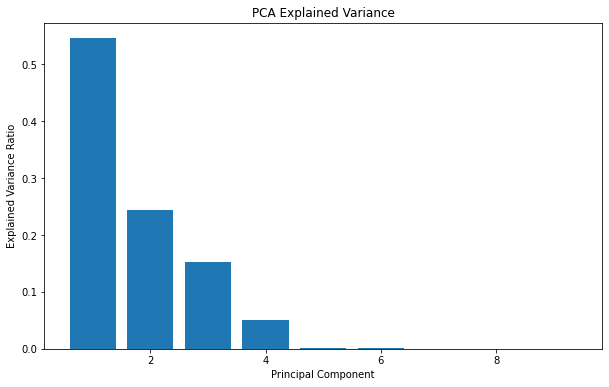


各主成分解释方差比例: [5.46196960e-01 2.44874410e-01 1.53451201e-01 5.07722858e-02
 2.17078149e-03 1.94093567e-03 3.71675774e-04 1.75648103e-04
 1.91892481e-05]
累计解释方差比例: [0.54619696 0.79107137 0.94452257 0.99529486 0.99746564 0.99940657
 0.99977825 0.9999539  0.99997309]
训练集大小: (31752, 9), 测试集大小: (7939, 9)


In [6]:
# 定义特征列和目标列
scaled_feature_columns = [
    "震源深度",
    "震中距",
    "仪器烈度",
    "总峰值加速度PGA",
    "总峰值速度PGV",
    "参考Vs30",
    "东西分量PGA",
    "南北分量PGA",
    "竖向分量PGA",
    "东西分量PGV",
    "南北分量PGV",
    "竖向分量PGV",
]

target_column = "震级"

# 提取特征和目标
X = df[scaled_feature_columns].values
y = df[target_column].values

# %%
# 应用PCA
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X)

# 可视化解释方差
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

print("\n各主成分解释方差比例:", pca.explained_variance_ratio_)
print("累计解释方差比例:", np.cumsum(pca.explained_variance_ratio_))

# %%
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="", threshold=0.5):
    """
    评估回归模型并返回RMSE和准确率
    
    参数:
    model: 已训练的模型
    X_train, y_train: 训练数据
    X_test, y_test: 测试数据
    model_name: 模型名称(用于打印)
    threshold: 准确率计算的阈值
    
    返回:
    rmse: 测试集上的RMSE
    accuracy: 测试集上的准确率(预测值与真实值差在±threshold内)
    """
    # 交叉验证RMSE
    cv_scores = -cross_val_score(model, X_train, y_train, 
                                scoring='neg_root_mean_squared_error', cv=3)
    avg_cv_rmse = np.mean(cv_scores)
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 测试集预测
    y_pred = model.predict(X_test)
    
    # 计算测试集RMSE
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # 计算准确率
    correct_predictions = np.abs(y_test - y_pred) <= threshold
    accuracy = np.mean(correct_predictions)
    
    # 打印结果
    if model_name:
        print(f"\n{model_name} 评估结果:")
        print(f"交叉验证平均RMSE: {avg_cv_rmse:.4f}")
        print(f"测试集RMSE: {test_rmse:.4f}")
        print(f"测试集准确率(±{threshold}): {accuracy:.4f}")
    
    return test_rmse, accuracy

In [8]:
# 初始化模型
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=2, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, max_depth=10, random_state=42)
}

# 评估每个模型
results = {}
for name, model in models.items():
    rmse, accuracy = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results[name] = {"RMSE": rmse, "Accuracy": accuracy}


C:\Users\韩金硕\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Linear Regression 评估结果:
交叉验证平均RMSE: 1.2682
测试集RMSE: 0.4862
测试集准确率(±0.5): 0.7167


C:\Users\韩金硕\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Decision Tree 评估结果:
交叉验证平均RMSE: 0.2629
测试集RMSE: 0.2478
测试集准确率(±0.5): 0.9397


C:\Users\韩金硕\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Random Forest 评估结果:
交叉验证平均RMSE: 0.2212
测试集RMSE: 0.2104
测试集准确率(±0.5): 0.9570

Gradient Boosting 评估结果:
交叉验证平均RMSE: 0.1649
测试集RMSE: 0.1525
测试集准确率(±0.5): 0.9793


C:\Users\韩金硕\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# 将结果转换为DataFrame便于展示
results_df = pd.DataFrame(results).T
print("\n模型性能比较:")
display(results_df)






模型性能比较:


,RMSE,Accuracy
Linear Regression,0.486172,0.716715
Decision Tree,0.247822,0.939665
Random Forest,0.210444,0.957047
Gradient Boosting,0.152483,0.979342


C:\Users\韩金硕\AppData\Local\Temp\ipykernel_27596\3409646061.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([f"{x*100:.0f}%" for x in ax2.get_xticks()])


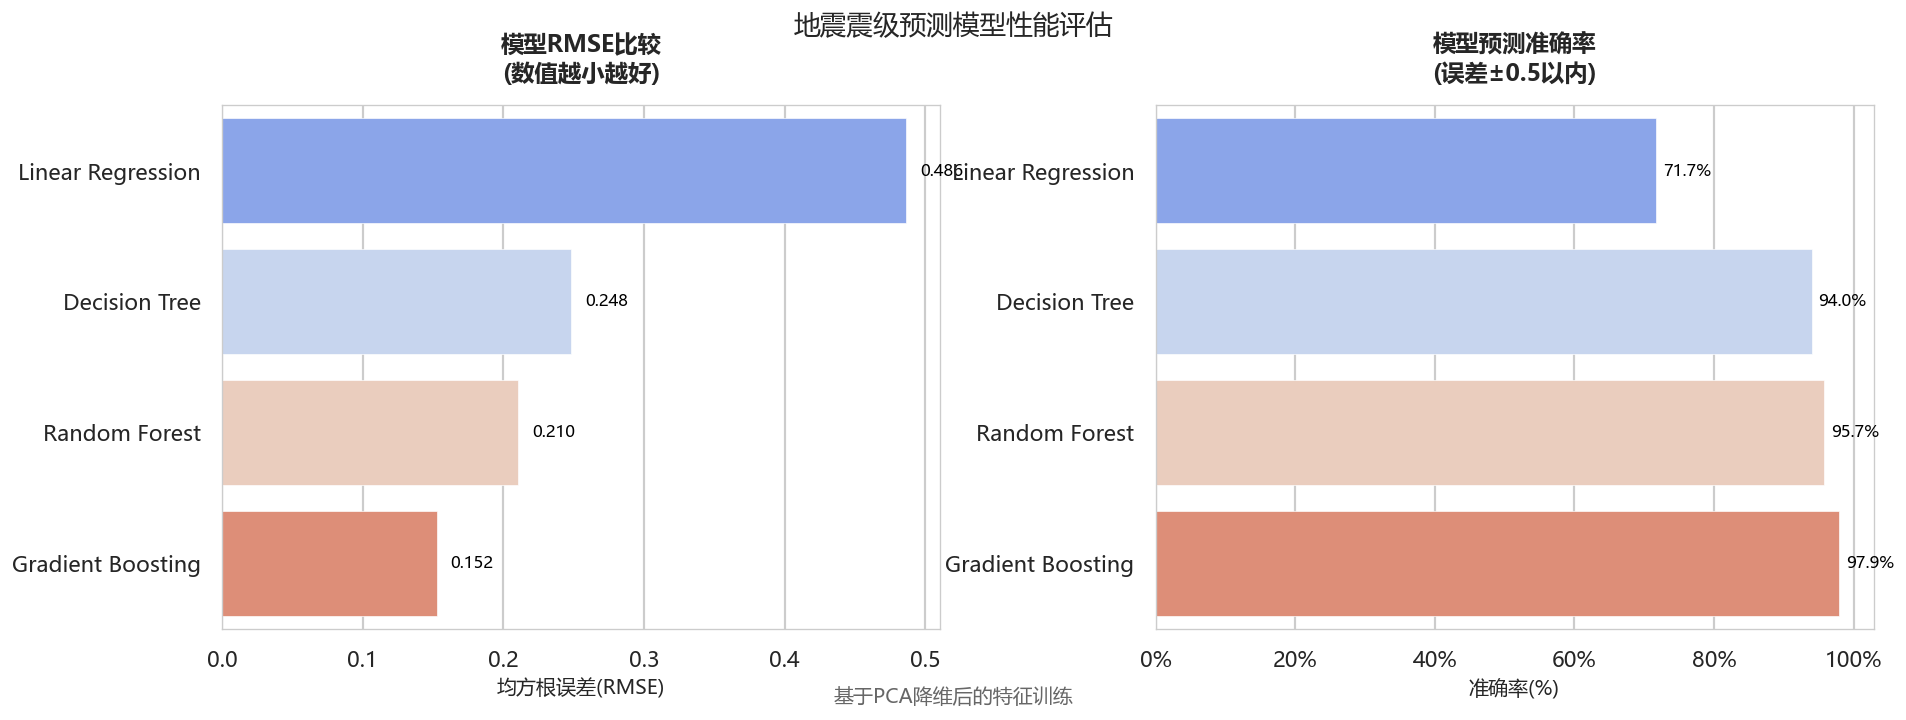

In [15]:
# 设置更专业的美学参数
plt.style.use('seaborn-talk')  # 使用适合展示的样式
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微软雅黑
plt.rcParams['axes.titleweight'] = 'bold'  # 标题加粗

# 创建图表
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=120)

# 自定义调色板
palette = sns.color_palette("coolwarm", n_colors=len(results_df))

# RMSE比较 - 水平条形图
sns.barplot(y=results_df.index, x=results_df['RMSE'], 
           palette=palette, ax=ax1, orient='h')
ax1.set_title('模型RMSE比较\n(数值越小越好)', fontsize=14, pad=15)
ax1.set_xlabel('均方根误差(RMSE)', fontsize=12)
ax1.set_ylabel('')

# 添加数据标签
for i, v in enumerate(results_df['RMSE']):
    ax1.text(v + 0.01, i, f"{v:.3f}", color='black', va='center', fontsize=10)

# 准确率比较 - 水平条形图
sns.barplot(y=results_df.index, x=results_df['Accuracy'], 
           palette=palette, ax=ax2, orient='h')
ax2.set_title('模型预测准确率\n(误差±0.5以内)', fontsize=14, pad=15)
ax2.set_xlabel('准确率(%)', fontsize=12)
ax2.set_ylabel('')
ax2.set_xticklabels([f"{x*100:.0f}%" for x in ax2.get_xticks()])

# 添加数据标签
for i, v in enumerate(results_df['Accuracy']):
    ax2.text(v + 0.01, i, f"{v*100:.1f}%", color='black', va='center', fontsize=10)

# 调整布局
plt.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.3)

# 添加整体标题和注释
fig.suptitle('地震震级预测模型性能评估', fontsize=16, y=0.98)
fig.text(0.5, 0.02, '基于PCA降维后的特征训练', ha='center', fontsize=12, alpha=0.7)

plt.show()